Char 2 Char machine translation from German to English
* source: Keras Applications

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 20000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = "data/deu.txt"

In [3]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

In [4]:
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

In [5]:
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    
    target_text = "\t" + target_text + "\n"
    
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    #populating the sets with all the various characters used in the process
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
            
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)
            

In [6]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))

num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)

max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [7]:
input_token_index = {char:i for i,char in enumerate(input_characters)}
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

Make the encoder and decoder input data

In [8]:
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype=np.float32)
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype=np.float32)
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype=np.float32)

In [9]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
        
    encoder_input_data[i, t + 1:, input_token_index[" "]] = 1.0
    
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
            
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

Build the model

In [10]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens)) #batch size not mentioned
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [11]:
model.compile(optimizer='rmsprop',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=.2)

model.save("s2schar.h5")

Epoch 1/100
250/250 [==============================] - 16s 36ms/step - loss: 0.8733 - accuracy: 0.7862 - val_loss: 0.7097 - val_accuracy: 0.8089
Epoch 2/100
250/250 [==============================] - 7s 30ms/step - loss: 0.5379 - accuracy: 0.8493 - val_loss: 0.5553 - val_accuracy: 0.8414
Epoch 3/100
250/250 [==============================] - 7s 30ms/step - loss: 0.4490 - accuracy: 0.8706 - val_loss: 0.5026 - val_accuracy: 0.8548
Epoch 4/100
250/250 [==============================] - 7s 30ms/step - loss: 0.4016 - accuracy: 0.8837 - val_loss: 0.4564 - val_accuracy: 0.8676
Epoch 5/100
250/250 [==============================] - 7s 30ms/step - loss: 0.3702 - accuracy: 0.8926 - val_loss: 0.4393 - val_accuracy: 0.8732
Epoch 6/100
250/250 [==============================] - 7s 30ms/step - loss: 0.3468 - accuracy: 0.8990 - val_loss: 0.4072 - val_accuracy: 0.8810
Epoch 7/100
250/250 [==============================] - 7s 30ms/step - loss: 0.3264 - accuracy: 0.9048 - val_loss: 0.3917 - val_accuracy

250/250 [==============================] - 8s 33ms/step - loss: 0.0854 - accuracy: 0.9747 - val_loss: 0.4306 - val_accuracy: 0.9060
Epoch 58/100
250/250 [==============================] - 8s 33ms/step - loss: 0.0837 - accuracy: 0.9752 - val_loss: 0.4359 - val_accuracy: 0.9060
Epoch 59/100
250/250 [==============================] - 8s 34ms/step - loss: 0.0821 - accuracy: 0.9757 - val_loss: 0.4373 - val_accuracy: 0.9055
Epoch 60/100
250/250 [==============================] - 8s 33ms/step - loss: 0.0807 - accuracy: 0.9760 - val_loss: 0.4399 - val_accuracy: 0.9059
Epoch 61/100
250/250 [==============================] - 8s 34ms/step - loss: 0.0791 - accuracy: 0.9765 - val_loss: 0.4451 - val_accuracy: 0.9059
Epoch 62/100
250/250 [==============================] - 8s 34ms/step - loss: 0.0779 - accuracy: 0.9768 - val_loss: 0.4500 - val_accuracy: 0.9052
Epoch 63/100
250/250 [==============================] - 8s 34ms/step - loss: 0.0764 - accuracy: 0.9772 - val_loss: 0.4526 - val_accuracy: 0.905

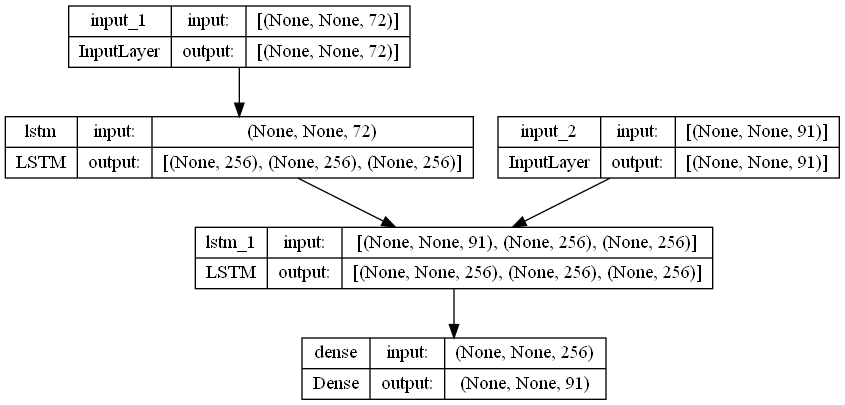

In [13]:
keras.utils.plot_model(model, 's2schar.png', show_shapes=True)

Inference on the model

In [14]:
encoder_inputs = model.input[0]
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

In [16]:
decoder_inputs = model.input[1]
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]

decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)

decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = keras.Model(
    [decoder_inputs]+decoder_states_inputs, [decoder_outputs] + decoder_states)

In [18]:
#Reverse-lookup token index
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [44]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq, verbose=0);

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0);

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [54]:
for seq_index in range(0,150,10):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

-
Input sentence: Hi.
Decoded sentence: Grüßart!

-
Input sentence: Go on.
Decoded sentence: Mach weiter.

-
Input sentence: Eat up.
Decoded sentence: Iss auf.

-
Input sentence: Hug me.
Decoded sentence: Dreck mich.

-
Input sentence: I paid.
Decoded sentence: Ich habe es versprochen.

-
Input sentence: No way!
Decoded sentence: Das kommt notot!

-
Input sentence: We try.
Decoded sentence: Wir versuchen es.

-
Input sentence: Be nice.
Decoded sentence: Seien Sie nett!

-
Input sentence: Beat it.
Decoded sentence: Mach dich vom Acker!

-
Input sentence: Come in.
Decoded sentence: Komm herein.

-
Input sentence: Get out.
Decoded sentence: Geht raus!

-
Input sentence: Go away!
Decoded sentence: Scher dich weg!

-
Input sentence: Go away.
Decoded sentence: Verdufte!

-
Input sentence: Go away.
Decoded sentence: Verdufte!

-
Input sentence: Goodbye!
Decoded sentence: Tschüss!

